# Quanto Option Pricing and Analysis
### Author: Omar Faruque

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import qflib as qf

qf.version()

'1.0.0-debug'

**Verify that as the strike of the quanto call goes to zero, the price goes towards the discounted quanto forward:**


=== Quanto Call Price Convergence Test ===
Discounted Quanto Forward           : 101.00501671
Quanto Call Price (Strike=1.00e-10) : 101.00501671
Absolute Error                      : 9.80e-11
Relative Error                      : 9.70e-13


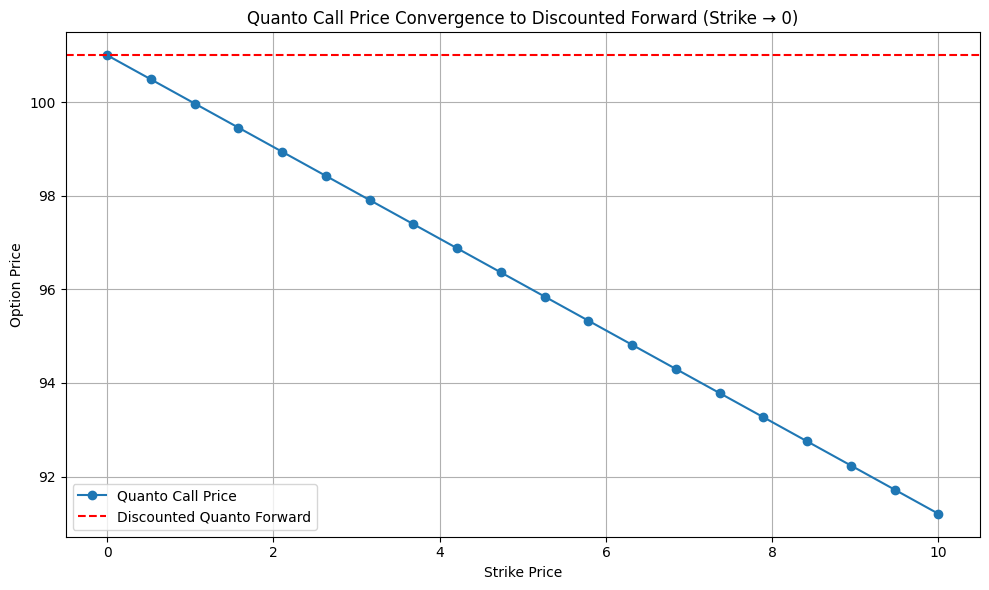

In [2]:
# === Setup ===
spot = 100.0
timetoexp = 1.0
payofftype = 1

divyield = 0.01
assetvol = 0.2
fxvol = 0.15
correl = 0.5

# discount and growth curves
discount_maturities = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
discount_rates = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035]

growth_maturities = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
growth_rates = [0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

discount_curve_name = "DiscountCurve"
growth_curve_name = "GrowthCurve"

qf.mktClear()
qf.ycCreate(discount_curve_name, discount_maturities, discount_rates, 0)
qf.ycCreate(growth_curve_name, growth_maturities, growth_rates, 0)


# Extract rates at 1 year
rate_1yr = discount_rates[2]   # 0.02
growth_1yr = growth_rates[2]   # 0.025

# Compute quanto drift
mu_q = growth_1yr - divyield + correl * assetvol * fxvol

# === Compute Discounted Quanto Forward ===
fwd = spot * np.exp((growth_1yr - divyield) * timetoexp)
quanto_fwd = fwd * np.exp(correl * assetvol * fxvol * timetoexp)
discount_factor = np.exp(-rate_1yr * timetoexp)
discounted_quanto_forward = quanto_fwd * discount_factor

# === Strikes Going to 0 ===
strike_list = np.linspace(1e-10, 10.0, 20)
prices = []

for strike in strike_list:
    price = qf.qEuroBS(
        payofftype,
        spot,
        strike,
        timetoexp,
        rate_1yr,
        growth_1yr,
        divyield,
        assetvol,
        fxvol,
        correl
    )
    prices.append(price)

prices = np.array(prices)

# === Print Results ===
print("\n=== Quanto Call Price Convergence Test ===")
print(f"Discounted Quanto Forward           : {discounted_quanto_forward:.8f}")

quanto_price_near_zero = prices[0]
strike_near_zero = strike_list[0]

print(f"Quanto Call Price (Strike={strike_near_zero:.2e}) : {quanto_price_near_zero:.8f}")

abs_error = abs(quanto_price_near_zero - discounted_quanto_forward)
rel_error = abs_error / discounted_quanto_forward
print(f"Absolute Error                      : {abs_error:.2e}")
print(f"Relative Error                      : {rel_error:.2e}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(strike_list, prices, marker='o', label="Quanto Call Price")
plt.axhline(discounted_quanto_forward, color='red', linestyle='--', label="Discounted Quanto Forward")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Quanto Call Price Convergence to Discounted Forward (Strike → 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As the strike price approaches 0 the quanto call price approaches the discounted quanto forward.

**Set up a Python notebook that compares the quanto option pricing of the MC and PDE methods
against the analytical solution. Make sure that the MC and PDE methods have converged:**

=== Quanto Option Pricing Results ===

=== Analytical Results ===
Manual Black-Scholes Price      : 9.50800966
Analytical Price (qflib)        : 9.50800966
Absolute Difference             : 1.42e-14
Relative Difference             : 1.49e-15

=== Monte Carlo Results ===
Monte Carlo Price (qflib)       : 9.50758241
Monte Carlo Std Error           : 0.00142529
Absolute Error (MC vs Analytic) : 4.27e-04
Relative Error (MC vs Analytic) : 4.49e-05


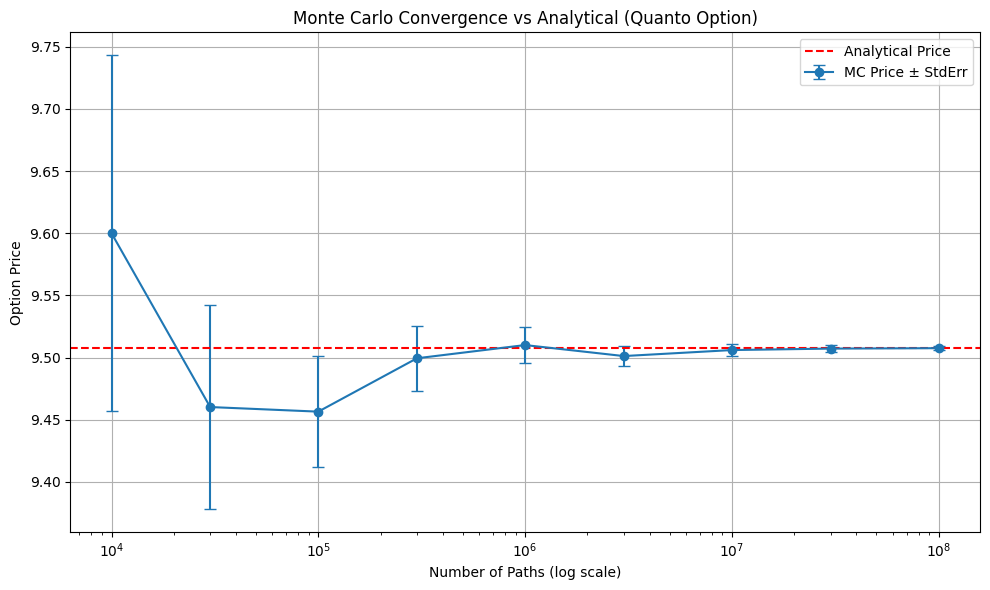


=== PDE Results ===
PDE Price (qflib)               : 9.50780061
Absolute Error (PDE vs Analytic): 2.09e-04
Relative Error (PDE vs Analytic): 2.20e-05


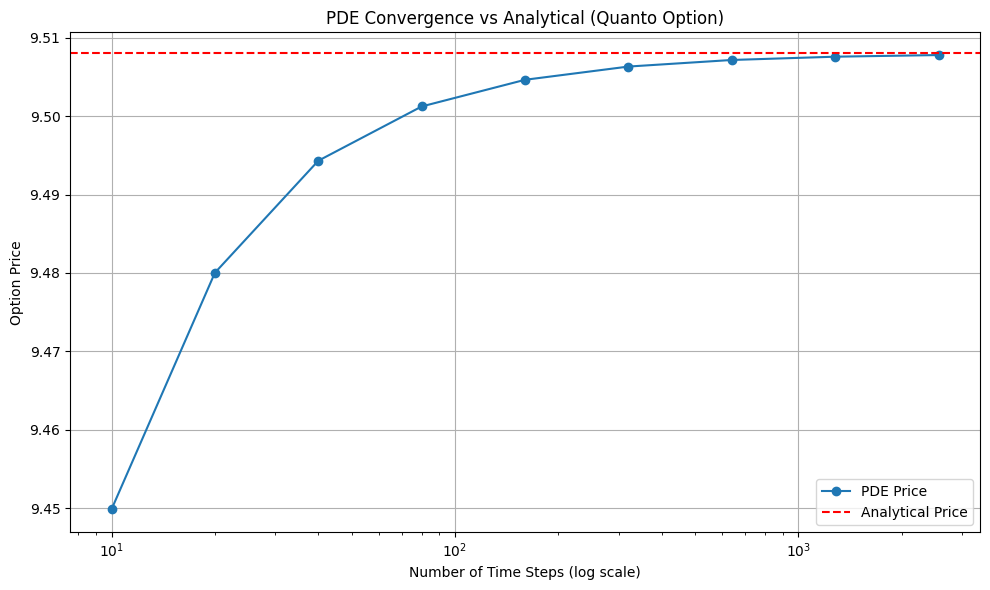

In [3]:
# === Setup ===
spot = 100.0
strike = 100.0
timetoexp = 1.0
payofftype = 1

divyield = 0.01
assetvol = 0.2
fxvol = 0.15
correl = 0.5

# Discount and growth curves
discount_maturities = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
discount_rates = [0.01, 0.012, 0.02, 0.023, 0.03, 0.035]
growth_maturities = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
growth_rates = [0.015, 0.018, 0.025, 0.03, 0.035, 0.04]

discount_curve_name = "DiscountCurve"
growth_curve_name = "GrowthCurve"

qf.mktClear()
qf.ycCreate(discount_curve_name, discount_maturities, discount_rates, 0)
qf.ycCreate(growth_curve_name, growth_maturities, growth_rates, 0)

# Spot discount and growth rate at 1 year for manual calculation
rate_1yr = discount_rates[2]   # 0.02
growth_1yr = growth_rates[2]   # 0.025
mu_q = growth_1yr - divyield + correl * assetvol * fxvol

# === Manual Analytical Price ===
def quanto_bs_call(S, K, T, r_d, mu_q, sigma):
    d1 = (np.log(S / K) + (mu_q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-r_d * T) * (S * np.exp(mu_q * T) * norm.cdf(d1) - K * norm.cdf(d2))

manual_price = quanto_bs_call(spot, strike, timetoexp, rate_1yr, mu_q, assetvol)

# === Analytical Price ===
qflib_price = qf.qEuroBS(
    payofftype, spot, strike, timetoexp,
    rate_1yr, growth_1yr, divyield,
    assetvol, fxvol, correl
)

# === Print Results ===
print("=== Quanto Option Pricing Results ===")

print(f"\n=== Analytical Results ===")
print(f"Manual Black-Scholes Price      : {manual_price:.8f}")
print(f"Analytical Price (qflib)        : {qflib_price:.8f}")
print(f"Absolute Difference             : {abs(manual_price - qflib_price):.2e}")
print(f"Relative Difference             : {abs(manual_price - qflib_price) / manual_price:.2e}")

# === Monte Carlo Pricing Params ===
mcparams = {"PATHGENTYPE": "EULER", "URNGTYPE": "MT19937"}

# === PDE Pricing Params ===
pdeparams = {
    "NTIMESTEPS": 1000,
    "NSPOTNODES": 4000,
    "NSTDDEVS": 4.0,
    "THETA": 0.5
}

# === Monte Carlo Convergence Plot ===
path_counts = [10_000, 30_000, 100_000, 300_000, 1_000_000, 3_000_000, 10_000_000, 30_000_000, 100_000_000]
mc_prices = []
mc_stderrs = []

for paths in path_counts:
    res = qf.qEuroBSMC(
        payofftype, strike, timetoexp, spot,
        discount_curve_name, growth_curve_name,
        divyield, assetvol, fxvol, correl,
        mcparams, paths
    )
    mc_prices.append(res['Price'])
    mc_stderrs.append(res['StdErr'])

# === Print Results ===
print(f"\n=== Monte Carlo Results ===")
print(f"Monte Carlo Price (qflib)       : {mc_prices[-1]:.8f}")
print(f"Monte Carlo Std Error           : {mc_stderrs[-1]:.8f}")
print(f"Absolute Error (MC vs Analytic) : {abs(mc_prices[-1] - qflib_price):.2e}")
print(f"Relative Error (MC vs Analytic) : {abs(mc_prices[-1] - qflib_price)/qflib_price:.2e}")

plt.figure(figsize=(10, 6))
plt.errorbar(path_counts, mc_prices, yerr=mc_stderrs, fmt='o-', capsize=4, label="MC Price ± StdErr")
plt.axhline(qflib_price, color='r', linestyle='--', label="Analytical Price")
plt.xscale('log')
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Option Price")
plt.title("Monte Carlo Convergence vs Analytical (Quanto Option)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PDE Convergence Plot ===
tsteps_list = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
nspotnodes_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
pde_prices = []

for nt, ns in zip(tsteps_list, nspotnodes_list):
    pdeparams = {
        "NTIMESTEPS": nt,
        "NSPOTNODES": ns,
        "NSTDDEVS": 4.0,
        "THETA": 0.5
    }
    res = qf.qEuroBSPDE(
        payofftype, strike, timetoexp, spot,
        discount_curve_name, growth_curve_name,
        divyield, assetvol, fxvol, correl,
        pdeparams, False
    )
    pde_prices.append(res["Price"])

# === Print Results ===
print(f"\n=== PDE Results ===")
print(f"PDE Price (qflib)               : {pde_prices[-1]:.8f}")
print(f"Absolute Error (PDE vs Analytic): {abs(pde_prices[-1] - qflib_price):.2e}")
print(f"Relative Error (PDE vs Analytic): {abs(pde_prices[-1] - qflib_price)/qflib_price:.2e}")

plt.figure(figsize=(10, 6))
plt.plot(tsteps_list, pde_prices, marker='o', label="PDE Price")
plt.axhline(qflib_price, color='r', linestyle='--', label="Analytical Price")
plt.xscale('log')
plt.xlabel("Number of Time Steps (log scale)")
plt.ylabel("Option Price")
plt.title("PDE Convergence vs Analytical (Quanto Option)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Python test script is designed to rigorously validate the pricing of a European quanto call option under a Black-Scholes framework by comparing multiple methods: an analytical formula, Monte Carlo simulation, and finite-difference PDE solving. First, the script manually creates non-flat discount and growth yield curves, representing realistic market environments where interest rates vary across maturities. The relevant discount rate (rate_1yr) and growth rate (growth_1yr) at exactly the option's maturity (1.0 year) are extracted to ensure proper inputs for the analytical Black-Scholes formula. The quanto-specific drift adjustment (mu_q) is computed to account for foreign-domestic currency exposure via correlation and volatilities only for manual calculation, otherwise this is calculated internally by the qflib library for the relevant functions. The true analytical price is then calculated using both the closed-form Black-Scholes formula and qflib’s qEuroBS function, ensuring internal consistency.

Next, a Monte Carlo simulation is run using qf.qEuroBSMC, with increasing numbers of paths to study statistical convergence. The Monte Carlo results are compared against the analytical benchmark by measuring absolute and relative errors, and a clear graph plots the MC prices along with error bars (standard errors), visually confirming convergence toward the analytical price as paths increase. Similarly, a PDE solver (qf.qEuroBSPDE) is tested for convergence by progressively refining both the number of time steps and spot nodes. The PDE graph directly shows how the PDE prices converge toward the analytical value as grid resolution increases.

Finally, the script prints a detailed summary: side-by-side listing of the analytical price, manual quanto price, Monte Carlo price (with standard error), and PDE price, with both absolute and relative errors computed for each method. The design allows a user to be sure that the qflib library is robust in pricing a quanto European option using 3 different methods: analytical, Monte Carlo, and PDE.

### **Question 1: Derive and verify numerically the call-put parity of quanto European calls and puts across several strikes and maturities.**

### Derivation of Quanto Call-Put Parity

A **quanto option** pays off in the domestic currency but is based on the **performance of a foreign asset**.

The price of a **quanto European call** and **put** satisfy a modified **call-put parity**, similar to the Black-Scholes case but adjusted for quanto features.

---

#### 1. Standard Call-Put Parity (Non-Quanto)

In regular Black-Scholes, the call-put parity is:

$$
\text{Call} - \text{Put} = D(T) \times (F(T) - K)
$$

where:
- $D(T) = e^{-r_d T}$ is the domestic discount factor.
- $F(T)$ is the forward price of the underlying asset at $T$.

---

#### 2. Quanto Forward Definition

In a quanto setup:
- The spot follows the foreign market but payoff is fixed in domestic currency.
- The **quanto-adjusted forward** $F_{\text{quanto}}(T)$ is:

$$
F_{\text{quanto}}(T) = S_0 \times e^{(r_f - q + \rho \sigma_S \sigma_Q)T}
$$

where:
- $r_f$ = foreign risk-free rate.
- $q$ = dividend yield.
- $\rho$ = correlation between stock and FX rate.
- $\sigma_S$ = volatility of stock.
- $\sigma_Q$ = volatility of FX rate.

Thus, **quanto forward** corrects the normal forward by an extra volatility-correlation term.

---

#### 3. Quanto Call-Put Parity

Thus, the **quanto call-put parity** becomes:

$$
\text{Call}_{\text{quanto}}(K, T) - \text{Put}_{\text{quanto}}(K, T) = D(T) \times (F_{\text{quanto}}(T) - K)
$$

where:
- $\text{Call}_{\text{quanto}}$ = price of quanto call.
- $\text{Put}_{\text{quanto}}$ = price of quanto put.
- $K$ = strike price.
- $T$ = maturity.

The difference between a quanto call and put equals the domestic discounted value of the quanto forward minus the strike.

---

#### 4. Summary

**Key differences from standard Black-Scholes parity**:
- The **forward** $F_{\text{quanto}}(T)$ includes a quanto adjustment term $\rho \sigma_S \sigma_Q$.
- Discounting is still based on the **domestic** interest rate $r_d$.

Thus, the parity relation ensures internal consistency of quanto option pricing across strikes and maturities.

---

### Final form

$$
\boxed{
\text{Call}_{\text{quanto}}(K, T) - \text{Put}_{\text{quanto}}(K, T) = e^{-r_d T} \left( S_0 e^{(r_f - q + \rho \sigma_S \sigma_Q)T} - K \right)
}
$$


In [4]:
# === Setup ===
spot = 100.0
strike_list = [80, 90, 100, 110, 120]
timetoexp_list = [0.5, 1.0, 2.0]    

divyield = 0.01
assetvol = 0.2
fxvol = 0.15
correl = 0.5

discount_rate = 0.02 #r_d domestic rate
growth_rate = 0.025  #r_f foreign rate

payofftype_call = 1
payofftype_put = -1

# === RHS ===
def discounted_quanto_forward(S0, T, r_f, q, rho, sigma_S, sigma_Q, r_d, K):
    quanto_fwd = S0 * np.exp((r_f - q + rho * sigma_S * sigma_Q) * T)
    return np.exp(-r_d * T) * (quanto_fwd - K)

# === Test ===
print("=== Quanto Put-Call Parity Verification  ===\n")

for timetoexp in timetoexp_list:
    print(f"=== Maturity (T) - {timetoexp} year(s) ===\n")
    print(f"{'Strike':>10} {'LHS':>20} {'RHS':>20} {'Abs Error':>15} {'Rel Error':>15}")
    print("-" * 90)

    for strike in strike_list:
        # Manual theoretical parity value
        RHS = discounted_quanto_forward(
            spot, timetoexp,
            growth_rate, divyield,
            correl, assetvol, fxvol,
            discount_rate, strike
        )

        # Prices from qf.qEuroBS
        call_price = qf.qEuroBS(
            payofftype_call, spot, strike, timetoexp,
            discount_rate, growth_rate, divyield,
            assetvol, fxvol, correl
        )

        put_price = qf.qEuroBS(
            payofftype_put, spot, strike, timetoexp,
            discount_rate, growth_rate, divyield,
            assetvol, fxvol, correl
        )

        call_minus_put = call_price - put_price
        abs_error = abs(call_minus_put - RHS)
        rel_error = abs_error / max(1e-12, abs(RHS))

        print(f"{strike:10.2f} {call_minus_put:20.8f} {RHS:20.8f} {abs_error:15.2e} {rel_error:15.2e}")

    print("\n")

=== Quanto Put-Call Parity Verification  ===

=== Maturity (T) - 0.5 year(s) ===

    Strike                  LHS                  RHS       Abs Error       Rel Error
------------------------------------------------------------------------------------------
     80.00          21.29726539          21.29726539        1.07e-14        5.00e-16
     90.00          11.39676705          11.39676705        0.00e+00        0.00e+00
    100.00           1.49626871           1.49626871        6.88e-15        4.60e-15
    110.00          -8.40422963          -8.40422963        5.33e-15        6.34e-16
    120.00         -18.30472796         -18.30472796        0.00e+00        0.00e+00


=== Maturity (T) - 1.0 year(s) ===

    Strike                  LHS                  RHS       Abs Error       Rel Error
------------------------------------------------------------------------------------------
     80.00          22.58912284          22.58912284        0.00e+00        0.00e+00
     90.00        

The left hand side of the equation:
$$
\text{Call}_{\text{quanto}}(K, T) - \text{Put}_{\text{quanto}}(K, T)$$ 
is equivalent to the right hand side of the equation:
$$
e^{-r_d T} \left( S_0 e^{(r_f - q + \rho \sigma_S \sigma_Q)T} - K \right)
$$
as shown by the absolute error and relative error in the table above.

### **Question 2: Study and demonstrate the effect of the asset/FX correlation $\rho$ on the option prices. Give an economic explanation for the dependence that you observe.**


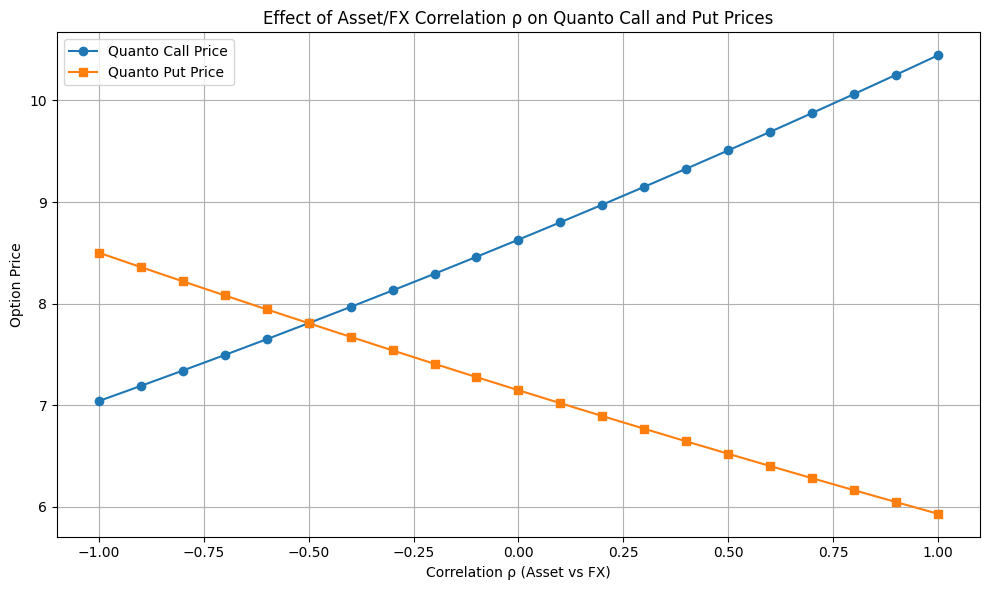

In [5]:
# === Setup ===
spot = 100.0
strike = 100.0
timetoexp = 1.0
payofftype_call = 1
payofftype_put = -1

divyield = 0.01
assetvol = 0.2
fxvol = 0.15

discount_maturities = [0.25, 0.5, 1.0, 2.0, 5.0]
discount_rates = [0.01, 0.012, 0.02, 0.025, 0.03]
growth_maturities = [0.25, 0.5, 1.0, 2.0, 5.0]
growth_rates = [0.015, 0.018, 0.025, 0.03, 0.035]

discount_curve_name = "DiscountCurve"
growth_curve_name = "GrowthCurve"

qf.mktClear()
qf.ycCreate(discount_curve_name, discount_maturities, discount_rates, 0)
qf.ycCreate(growth_curve_name, growth_maturities, growth_rates, 0)

discount_rate = discount_rates[2]  # 0.02
growth_rate = growth_rates[2]      # 0.025

# === Vary Correlations ===
rho_list = np.linspace(-1.0, 1.0, 21)  # from -1 to +1
call_prices = []
put_prices = []

for rho in rho_list:
    call_price = qf.qEuroBS(
        payofftype_call,
        spot,
        strike,
        timetoexp,
        discount_rate,
        growth_rate,
        divyield,
        assetvol,
        fxvol,
        rho
    )
    put_price = qf.qEuroBS(
        payofftype_put,
        spot,
        strike,
        timetoexp,
        discount_rate,
        growth_rate,
        divyield,
        assetvol,
        fxvol,
        rho
    )
    call_prices.append(call_price)
    put_prices.append(put_price)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(rho_list, call_prices, marker='o', label="Quanto Call Price")
plt.plot(rho_list, put_prices, marker='s', label="Quanto Put Price")
plt.xlabel("Correlation ρ (Asset vs FX)")
plt.ylabel("Option Price")
plt.title("Effect of Asset/FX Correlation ρ on Quanto Call and Put Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Summary of the Effect of Correlation ($\rho$) on Quanto Option Prices**

**Quanto Calls:**

As correlation $\rho$ increases quanto call price increases.

- When correlation $\rho$ > 0:
  - As the asset price rises, the FX rate also strengthens.
  - This increases the domestic payoff.
  - Result: The call option price increases.

- When correlation $\rho$ < 0:
  - As the asset price rises, the FX rate weakens.
  - This reduces the domestic payoff.
  - Result: The call option price decreases.

**Quanto Puts:**

As correlation $\rho$ increases quanto put price decreases.

- When correlation $\rho$ > 0:
  - As the asset price falls, the FX rate weakens.
  - This reduces the domestic payoff from a falling asset.
  - Result: The put option price decreases.

- When correlation $\rho$ < 0:
  - As the asset price falls, the FX rate strengthens.
  - This boosts the domestic payoff when the asset declines.
  - Result: The put option price increases.

**Mathematical Insight:**
- The effective drift adjustment is increased by $$\rho$ \times σ_S \times σ_Q$.
- A positive $\rho$ shifts the forward price upward, favoring calls.
- A negative $\rho$ shifts the forward price downward, favoring puts.

**Table Summary:**

| Correlation ($\rho$) | Effect on Call Price  | Effect on Put Price  |
|:----------------|:----------------------|:---------------------|
| $\rho$ > 0           | Call price increases   | Put price decreases   |
| $\rho$ = 0           | No special effect      | No special effect     |
| $\rho$ < 0           | Call price decreases   | Put price increases   |

**Economic Explanation:**
- Positive correlation makes rising asset prices more valuable domestically, increasing call option value.
- Negative correlation makes falling asset prices more valuable domestically, increasing put option value.
